# COVID19-related literature SQL database

In this notebook, we create a relational database dump of a set of COVID19-related publication datasets. These include:

* CORD19: https://pages.semanticscholar.org/coronavirus-research
* Dimensions: https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255
* WHO: https://www.who.int/emergencies/diseases/novel-coronavirus-2019/global-research-on-novel-coronavirus-2019-ncov

In [126]:
# magics, warnings and imports

%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, math, re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import pymysql
from sqlalchemy import create_engine
from sqlalchemy import Integer,String,Boolean,DateTime

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load datasets

In [127]:
# point here to the versions of the datasets you want to use
dimensions_filename = "datasets_input/Dimensions_03_06_2020.csv"
who_filename = "datasets_input/WHO_03_06_2020.csv"
cord19_folder = "datasets_input/CORD19_03_06_2020"

df_dimensions = pd.read_csv(dimensions_filename, dtype=str)
df_who = pd.read_csv(who_filename, dtype=str)
df_cord = pd.read_csv(os.path.join(cord19_folder,"metadata.csv"), dtype=str)

In [128]:
df_cord.shape

(135149, 19)

### Prepare dataframes for ingestion

#### Clean-up data frames

##### Dimensions

In [129]:
df_dimensions.head()

,Date added,Publication ID,DOI,PMID,PMCID,Title,Abstract,Source title,Source UID,Publisher,...,Research Organizations - standardized,GRID IDs,City of Research organization,Country of Research organization,Funder,UIDs of supporting grants,Times cited,Altmetric,Source Linkout,Dimensions URL
0,2020-05-20,pub.1127722683,10.4060/ca8799fr,NaN,NaN,Atténuer les effets de covid-19 sur le secteur...,NaN,NaN,NaN,Food and Agriculture Organization of the Unite...,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,https://app.dimensions.ai/details/publication/...
1,2020-05-20,pub.1127724804,10.7238/c.n99.2036,NaN,NaN,'Fake news' y coronavirus (y II): las redes so...,NaN,COMeIN,jour.1366192,Fundacio per la Universitat Oberta de Catalunya,...,Open University of Catalonia,grid.36083.3e,Barcelona,Spain,NaN,NaN,0,NaN,https://doi.org/10.7238/c.n99.2036,https://app.dimensions.ai/details/publication/...
2,2020-05-20,pub.1127722401,10.3934/mbe.2020205,NaN,NaN,Phase-adjusted estimation of the COVID-19 outb...,NaN,Mathematical Biosciences and Engineering,jour.1033105,American Institute of Mathematical Sciences (A...,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,https://doi.org/10.3934/mbe.2020205,https://app.dimensions.ai/details/publication/...
3,2020-05-20,pub.1127715363,10.1136/leader-2020-000273,NaN,NaN,What healthcare leaders need to do to protect ...,NaN,BMJ Leader,jour.1293146,BMJ,...,NaN,NaN,NaN,NaN,National Institute for Health Research,NaN,0,67,https://bmjleader.bmj.com/content/leader/early...,https://app.dimensions.ai/details/publication/...
4,2020-05-20,pub.1127717858,10.14336/ad.2020.0402,NaN,NaN,COVID-19 in India: Are Biological and Environm...,NaN,Aging and Disease,jour.1044156,Aging and Disease,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,http://www.aginganddisease.org/EN/article/down...,https://app.dimensions.ai/details/publication/...


In [130]:
df_dimensions.columns

Index(['Date added', 'Publication ID', 'DOI', 'PMID', 'PMCID', 'Title',
       'Abstract', 'Source title', 'Source UID', 'Publisher', 'MeSH terms',
       'Publication Date', 'PubYear', 'Volume', 'Issue', 'Pagination',
       'Open Access', 'Publication Type', 'Authors', 'Corresponding Authors',
       'Authors Affiliations', 'Research Organizations - standardized',
       'GRID IDs', 'City of Research organization',
       'Country of Research organization', 'Funder',
       'UIDs of supporting grants', 'Times cited', 'Altmetric',
       'Source Linkout', 'Dimensions URL'],
      dtype='object')

In [131]:
df_dimensions.drop(columns=['Date added', 'Publisher', 'Authors', 'Corresponding Authors',
       'Authors Affiliations', 'Research Organizations - standardized',
       'GRID IDs', 'City of Research organization',
       'Country of Research organization', 'Funder',
       'UIDs of supporting grants', 'Times cited', 'Altmetric',
       'Source Linkout'], inplace=True)

In [132]:
df_dimensions.columns

Index(['Publication ID', 'DOI', 'PMID', 'PMCID', 'Title', 'Abstract',
       'Source title', 'Source UID', 'MeSH terms', 'Publication Date',
       'PubYear', 'Volume', 'Issue', 'Pagination', 'Open Access',
       'Publication Type', 'Dimensions URL'],
      dtype='object')

In [133]:
df_dimensions.rename(columns={'Publication ID':'dimensions_id', 'DOI':'doi', 'PMID':'pmid', 'PMCID':'pmcid', 'Title':'title', 'Abstract':'abstract',
       'Source title':'journal', 'Source UID':'source_uid', 'MeSH terms':'mesh_terms', 'Publication Date':'publication_date',
       'PubYear':'publication_year', 'Volume':'volume', 'Issue':'issue', 'Pagination':'pages', 'Open Access':'open_access',
       'Publication Type':'publication_type', 'Dimensions URL':'dimensions_url'}, inplace=True)

In [134]:
def get_year(date):
    if isinstance(date,str) and len(date)>3 and date[:4].isdigit():
        return date[:4]
    return ""

month_to_number = {"Jan":"1","Feb":"2","Mar":"3","Apr":"4","May":"5","Jun":"6","Jul":"7","Aug":"8","Sep":"9","Oct":"10","Nov":"11","Dec":"12"}

def get_month(date):
    if isinstance(date,str) and len(date)>6:
        if "-" in date and date.split("-")[1].isdigit():
            return str(int(date.split("-")[1]))
        else:
            try:
                return month_to_number[date.split()[1]]
            except:
                return ""
    return ""

def sanitize_string(s):
    return " ".join(s.split())

In [135]:
df_dimensions["publication_year"] = df_dimensions["publication_year"].apply(get_year)
df_dimensions["publication_month"] = df_dimensions["publication_date"].apply(get_month)
df_dimensions["arxiv_id"] = ""

In [136]:
df_dimensions.drop(columns="publication_date", inplace=True)
df_dimensions = df_dimensions.fillna('')

In [137]:
# retrieve arXiv ID for Dimensions papers
# Sync option, quite slow

"""
import requests, re

for index, row in df_dimensions[df_dimensions.journal=="arXiv"].iterrows():
    r = requests.get(row["dimensions_url"])
    if r.status_code == 200:
        arxiv_url = re.search("https://arxiv.org/pdf/arXiv:[0-9]+.[0-9]+",r.text).group()
        arxiv_id = arxiv_url.split(":")[-1]
        row["arxiv_id"] = arxiv_id
"""

'\nimport requests, re\n\nfor index, row in df_dimensions[df_dimensions.journal=="arXiv"].iterrows():\n    r = requests.get(row["dimensions_url"])\n    if r.status_code == 200:\n        arxiv_url = re.search("https://arxiv.org/pdf/arXiv:[0-9]+.[0-9]+",r.text).group()\n        arxiv_id = arxiv_url.split(":")[-1]\n        row["arxiv_id"] = arxiv_id\n'

In [14]:
# from https://towardsdatascience.com/fast-and-async-in-python-accelerate-your-requests-using-asyncio-62dafca83c33
# aSync option, fast

import aiohttp
import requests
import asyncio

from aiohttp import ClientSession

def extract_fields_from_response(response):
    """Extract arxiv id from API's response"""
    search_res = re.search("arXiv:[0-9]+.[0-9]+",response)
    if search_res:
        arxiv_url = search_res.group()
        arxiv_id = arxiv_url.split(":")[-1]
        return arxiv_id
    return ""

async def get_details_async(session, payload):   
    response = await session.request(method='GET', url=payload[1]["dimensions_url"])
    if response.status != 200:
        print(payload[0], response.status)
        pass
    return await response.text()

async def run_program(session, payload):
    """Wrapper for running program in an asynchronous manner"""
    response = await get_details_async(session, payload)
    arxiv_id = extract_fields_from_response(response)
    return (arxiv_id,payload[1]["dimensions_url"])

payloads = df_dimensions[df_dimensions.journal=="arXiv"]
connector = aiohttp.TCPConnector(limit=5)
async with aiohttp.ClientSession(connector=connector) as session:
    results = await asyncio.gather(*[run_program(session, payload) for payload in payloads.iterrows()])

In [15]:
df_tmp = pd.DataFrame.from_dict({"arxiv_id":[x[0] for x in results],"dimensions_url":[x[1] for x in results]})

In [138]:
df_tmp.shape

(963, 2)

In [139]:
df_dimensions = df_dimensions.merge(df_tmp, how="left", left_on="dimensions_url", right_on="dimensions_url")
df_dimensions.drop(columns="arxiv_id_x", inplace=True)
df_dimensions.rename(columns={"arxiv_id_y":"arxiv_id"}, inplace=True)
df_dimensions = df_dimensions.fillna('')

In [140]:
df_dimensions.shape

(36835, 18)

In [141]:
df_dimensions[df_dimensions.journal=="arXiv"].shape

(965, 18)

In [142]:
df_dimensions.head()

,dimensions_id,doi,pmid,pmcid,title,abstract,journal,source_uid,mesh_terms,publication_year,volume,issue,pages,open_access,publication_type,dimensions_url,publication_month,arxiv_id
0,pub.1127722683,10.4060/ca8799fr,,,Atténuer les effets de covid-19 sur le secteur...,,,,,2020,,,,Closed,book,https://app.dimensions.ai/details/publication/...,1,
1,pub.1127724804,10.7238/c.n99.2036,,,'Fake news' y coronavirus (y II): las redes so...,,COMeIN,jour.1366192,,2020,,99,,All OA; Hybrid,article,https://app.dimensions.ai/details/publication/...,5,
2,pub.1127722401,10.3934/mbe.2020205,,,Phase-adjusted estimation of the COVID-19 outb...,,Mathematical Biosciences and Engineering,jour.1033105,,2020,17,4,3637-3648,All OA; Pure Gold,article,https://app.dimensions.ai/details/publication/...,1,
3,pub.1127715363,10.1136/leader-2020-000273,,,What healthcare leaders need to do to protect ...,,BMJ Leader,jour.1293146,,2020,,,leader-2020-000273,All OA; Bronze,article,https://app.dimensions.ai/details/publication/...,5,
4,pub.1127717858,10.14336/ad.2020.0402,,,COVID-19 in India: Are Biological and Environm...,,Aging and Disease,jour.1044156,,2020,11,3,480,All OA; Bronze,article,https://app.dimensions.ai/details/publication/...,1,


In [143]:
df_dimensions[df_dimensions.doi==""].shape

(1334, 18)

##### WHO

In [144]:
df_who.shape

(26573, 17)

In [145]:
df_who.head()

,ID,Title,Authors,Source,Journal,Database,Type,Language,Publication year,Descriptor(s),Publication Country,Fulltext URL,Abstract,Entry Date,Volume number,Issue number,DOI
0,437999,The dissemination of COVID-19: an expectant an...,"Pimentel, Renata Macedo Martins; Daboin, Blanc...",Rev. bras. crescimento desenvolv. hum;30(1)2020.,Rev. bras. crescimento desenvolv. hum,LILACS,article,en,2020,"Humans; Health Knowledge, Attitudes, Practice;...",BR,http://revistas.marilia.unesp.br/index.php/jhg...,Backgroung: Coronaviruses (CoV) make up a larg...,202060,30,1,
1,437630,Hidroxicloroquina y azitromicina: riesgo cardi...,"Barja, Luis D; Maurice, Mario Fitz; González, ...",CorSalud;12(1)ene.-mar. 2020.,CorSalud,LILACS,article,es,2020,Humans; Long QT Syndrome/etiology; Coronavirus...,CU,http://www.revcorsalud.sld.cu/index.php/cors/a...,NaN,202060,12,1,
2,326028,Grupo de Trabajo en material de salud en los c...,Perú. Ministerio de Salud,Lima; Perú. Ministerio de Salud; 20200500. 4 p.,NaN,LILACS,monography,es,2020,Professional Staff Committees; Occupational He...,PE,http://fi-admin.bvsalud.org/document/view/cj7ej,El documento contiene la conformación del Grup...,202052,NaN,NaN,
3,326027,Lineamientos para el fortalecimiento de accion...,Perú. Ministerio de Salud; Dirección General d...,Lima; Perú. Ministerio de Salud; 20200500. 14 p.,NaN,LILACS,monography,es,2020,National Strategies; Coronavirus Infections; M...,PE,http://fi-admin.bvsalud.org/document/view/mf38b,El documento contiene las directrices para ori...,202052,NaN,NaN,
4,326024,Directiva sanitaria que establece las disposic...,Perú. Ministerio de Salud; Dirección General d...,Lima; Perú. Ministerio de Salud; 20200500. 25 p.,NaN,LILACS,monography,es,2020,Guidelines as Topic; Coronavirus Infections; C...,PE,http://fi-admin.bvsalud.org/document/view/rymmc,El documento contiene las disposiciones y medi...,202052,NaN,NaN,


In [146]:
df_who.columns

Index(['ID', 'Title', 'Authors', 'Source', 'Journal', 'Database', 'Type',
       'Language', 'Publication year', 'Descriptor(s)', 'Publication Country',
       'Fulltext URL', ' Abstract', 'Entry Date', 'Volume number',
       'Issue number', 'DOI'],
      dtype='object')

In [147]:
df_who.drop(columns=["ID","Authors","Publication Country","Fulltext URL"], inplace=True)

In [156]:
df_who.rename(columns={'Title':'title', 'DOI':'doi', ' Abstract': 'abstract', 'Source': 'WHO_source', 'Database': 'WHO_database', 'Type': 'WHO_type',
        'Publication year':'publication_year', 'Language': 'WHO_language', 'Descriptor(s)': 'WHO_descriptors',
       'Journal':'journal', 'Volume number':'volume', 'Issue number':'issue', 'Entry Date':'WHO_entry_date'}, inplace=True)

In [157]:
# NEW
# WHO_source
# WHO_database
# WHO_type
# WHO_language
# WHO_descriptors
# WHO_entry_date

In [158]:
df_who["pmid"] = ""
df_who["pmcid"] = ""
df_who["dimensions_id"] = ""
df_who["arxiv_id"] = ""
df_who["publication_month"] = ""
df_who["pages"] = ""
df_who = df_who.fillna('')

In [159]:
df_who.head()

,title,WHO_source,journal,WHO_database,WHO_type,WHO_language,publication_year,WHO_descriptors,abstract,WHO_entry_date,volume,issue,doi,pmid,pmcid,dimensions_id,arxiv_id,publication_month,pages
0,The dissemination of COVID-19: an expectant an...,Rev. bras. crescimento desenvolv. hum;30(1)2020.,Rev. bras. crescimento desenvolv. hum,LILACS,article,en,2020,"Humans; Health Knowledge, Attitudes, Practice;...",Backgroung: Coronaviruses (CoV) make up a larg...,202060,30,1,,,,,,,
1,Hidroxicloroquina y azitromicina: riesgo cardi...,CorSalud;12(1)ene.-mar. 2020.,CorSalud,LILACS,article,es,2020,Humans; Long QT Syndrome/etiology; Coronavirus...,,202060,12,1,,,,,,,
2,Grupo de Trabajo en material de salud en los c...,Lima; Perú. Ministerio de Salud; 20200500. 4 p.,,LILACS,monography,es,2020,Professional Staff Committees; Occupational He...,El documento contiene la conformación del Grup...,202052,,,,,,,,,
3,Lineamientos para el fortalecimiento de accion...,Lima; Perú. Ministerio de Salud; 20200500. 14 p.,,LILACS,monography,es,2020,National Strategies; Coronavirus Infections; M...,El documento contiene las directrices para ori...,202052,,,,,,,,,
4,Directiva sanitaria que establece las disposic...,Lima; Perú. Ministerio de Salud; 20200500. 25 p.,,LILACS,monography,es,2020,Guidelines as Topic; Coronavirus Infections; C...,El documento contiene las disposiciones y medi...,202052,,,,,,,,,


In [160]:
df_who.doi.value_counts()

                                       21352
10.1097/01.Cot.0000660220.29383.61         4
10.1016/j.anrea.2020.04.006                3
10.4264/numa.79.1_47                       3
10.1016/j.midw.2020.102668                 3
                                       ...  
10.1016/j.msard.2020.102249                1
10.1016/j.jor.2020.06.001                  1
10.1097/txd.0000000000001002               1
10.4103/ijoem.IJOEM_49_20                  1
10.1080/15563650.2020.1741981              1
Name: doi, Length: 5116, dtype: int64

##### CORD19

In [161]:
df_cord.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [162]:
df_cord["license"].value_counts()

unk            60414
no-cc          37231
cc-by          12920
els-covid      12895
medrxiv         3903
cc-by-nc        1676
arxiv           1565
biorxiv         1063
cc-by-nc-nd     1026
green-oa         859
cc-by-nc-sa      588
bronze-oa        566
cc0              281
hybrid-oa        115
gold-oa           38
cc-by-nd           7
cc-by-sa           2
Name: license, dtype: int64

In [163]:
df_cord["source_x"].value_counts()

Medline                               43392
PMC                                   23898
Medline; PMC                          19691
Elsevier; Medline; PMC                13640
WHO                                   13188
Elsevier; Medline; PMC; WHO            3733
Medline; WHO                           3707
MedRxiv                                3665
Elsevier; PMC                          2586
Medline; PMC; WHO                      2569
ArXiv                                  1541
Elsevier; PMC; WHO                     1237
BioRxiv                                 961
PMC; WHO                                507
BioRxiv; MedRxiv                        338
Elsevier                                143
Elsevier; Medline                       103
Elsevier; WHO                            87
Elsevier; Medline; WHO                   86
ArXiv; Medline; PMC                      24
ArXiv; Medline                           16
ArXiv; Elsevier; Medline; PMC            13
ArXiv; Elsevier; Medline; PMC; W

In [164]:
# how many full text files
df_cord[(pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files))].shape

(65075, 19)

In [165]:
df_cord[(pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files))].shape[0]/df_cord.shape[0]

0.4815055975256939

In [166]:
# check Medline
df_cord[(df_cord.source_x=="Medline")&((pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files)))].shape[0]/df_cord[(df_cord.source_x=="Medline")].shape[0]

0.0

In [167]:
df_cord[(df_cord.source_x=="Medline")].shape[0]

43392

In [168]:
# check NOT Medline
df_cord[(df_cord.source_x!="Medline")&((pd.notnull(df_cord.pdf_json_files))|(pd.notnull(df_cord.pmc_json_files)))].shape[0]/df_cord[(df_cord.source_x!="Medline")].shape[0]

0.70921019649727

In [169]:
df_cord[(df_cord.source_x!="Medline")].shape[0]

91757

In [170]:
# NEW columns (for now, we drop)
df_cord.drop(columns=["cord_uid","url","pdf_json_files","pmc_json_files","s2_id"],inplace=True)

In [171]:
df_cord.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id'],
      dtype='object')

In [172]:
df_cord.drop(columns='authors', inplace=True)
df_cord = df_cord.fillna('')

In [173]:
df_cord.rename(columns={'source_x':'source', 'pubmed_id': 'pmid',
       'mag_id': 'ms_academic_id', 'who_covidence_id': 'who_covidence'}, inplace=True)

In [174]:
df_cord["publication_year"] = df_cord["publish_time"].apply(get_year)
df_cord["publication_month"] = df_cord["publish_time"].apply(get_month)

In [175]:
df_cord.drop(columns='publish_time', inplace=True)

In [176]:
df_cord['pages'] = ""
df_cord['volume'] = ""
df_cord['issue'] = ""
df_cord["dimensions_id"] = ""

In [177]:
df_cord.head()

,sha,source,title,doi,pmcid,pmid,license,abstract,journal,ms_academic_id,who_covidence,arxiv_id,publication_year,publication_month,pages,volume,issue,dimensions_id
0,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,BMC Infect Dis,,,,2001,7,,,,
1,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,Respir Res,,,,2000,8,,,,
2,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,Respir Res,,,,2000,8,,,,
3,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,Respir Res,,,,2001,2,,,,
4,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,Respir Res,,,,2001,5,,,,


In [178]:
df_cord[(df_cord.doi=="") & ((df_cord.sha!="") | (df_cord.pmid!="") | (df_cord.pmcid!="") | df_cord.arxiv_id!="")].shape

(24046, 18)

In [179]:
df_cord[(df_cord.doi=="") & (df_cord.pmid=="") & (df_cord.pmcid=="")].shape

(13331, 18)

In [180]:
df_cord[((df_cord.doi=="") & (df_cord.pmid=="") & (df_cord.pmcid==""))&(df_cord.arxiv_id!="")].shape

(1471, 18)

In [181]:
df_dimensions.shape

(36835, 18)

In [182]:
df_who.shape

(26573, 19)

In [183]:
df_cord.shape

(135149, 18)

In [184]:
df_dimensions[((df_dimensions.doi=="") & (df_dimensions.pmid=="") & (df_dimensions.pmcid==""))&(df_dimensions.journal=="arXiv")].shape

(965, 18)

In [185]:
df_dimensions[df_dimensions.journal=="arXiv"].shape

(965, 18)

In [186]:
df_cord[df_cord.arxiv_id!=""].shape

(1616, 18)

In [187]:
df_cord[df_cord.title=="CORD-19: The Covid-19 Open Research Dataset"]

,sha,source,title,doi,pmcid,pmid,license,abstract,journal,ms_academic_id,who_covidence,arxiv_id,publication_year,publication_month,pages,volume,issue,dimensions_id
77323,bc411487f305e451d7485e53202ec241fcc97d3b,ArXiv,CORD-19: The Covid-19 Open Research Dataset,,,,arxiv,The Covid-19 Open Research Dataset (CORD-19) i...,,,,2004.10706,2020,4,,,,


In [188]:
df_dimensions[df_dimensions.title=="CORD-19: The Covid-19 Open Research Dataset"]

,dimensions_id,doi,pmid,pmcid,title,abstract,journal,source_uid,mesh_terms,publication_year,volume,issue,pages,open_access,publication_type,dimensions_url,publication_month,arxiv_id
17408,pub.1126924428,,,,CORD-19: The Covid-19 Open Research Dataset,,arXiv,jour.1371339,,2020,,,,"All OA; Green, Submitted",preprint,https://app.dimensions.ai/details/publication/...,4,2004.10706


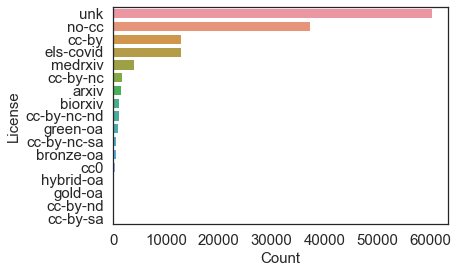

In [189]:
# license
df_sub = df_cord[df_cord.license.isin(df_cord.license.value_counts()[:30].index.tolist())]
b = sns.countplot(y="license", data=df_sub, order=df_sub['license'].value_counts().index)
#b.axes.set_title("Title",fontsize=50)
b.set_xlabel("Count",fontsize=15)
b.set_ylabel("License",fontsize=15)
b.tick_params(labelsize=15)

### Prepare tables

In [190]:
# the main table: pub

In [191]:
pub_table_columns = ['title','abstract','publication_year','publication_month','journal','volume','issue','pages','doi','pmid','pmcid','dimensions_id','arxiv_id']

df_pub = df_dimensions[pub_table_columns].append(df_who[pub_table_columns], ignore_index = True)

In [192]:
df_pub = df_pub[pub_table_columns].append(df_cord[pub_table_columns], ignore_index=True)

In [193]:
df_pub["title"] = df_pub["title"].apply(sanitize_string)
df_pub["abstract"] = df_pub["abstract"].apply(sanitize_string)
df_pub["doi"] = df_pub["doi"].apply(str.lower)
df_pub["pmid"] = df_pub["pmid"].apply(str.lower)
df_pub["pmcid"] = df_pub["pmcid"].apply(str.lower)
df_pub["dimensions_id"] = df_pub["dimensions_id"].apply(str.lower)
df_pub["arxiv_id"] = df_pub["arxiv_id"].apply(str.lower)

In [194]:
df_pub.shape

(198557, 13)

In [195]:
df_pub[(df_pub.doi=="") & (df_pub.pmid=="") & (df_pub.pmcid=="") & (df_pub.dimensions_id=="") & (df_pub.arxiv_id=="")].shape

(11860, 13)

In [196]:
# check to have at least one valid identifier per publication
# we drop publications which do not: hopefully, they will be equipped with an identifier in future releases

df_pub = df_pub[~((df_pub.doi=="") & (df_pub.pmid=="") & (df_pub.pmcid=="") & (df_pub.dimensions_id=="") & (df_pub.arxiv_id==""))]

In [197]:
df_pub[df_pub.doi=="0.1126/science.abb7331"]

,title,abstract,publication_year,publication_month,journal,volume,issue,pages,doi,pmid,pmcid,dimensions_id,arxiv_id


In [198]:
# drop duplicates, first on dois then pmids then pmcids. We need this to keep empty values!
df_tmp = df_pub[df_pub.doi==""]
df_pub1 = df_pub[df_pub.doi!=""].groupby('doi').first()
df_pub1.reset_index(inplace=True)
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_pub2 = df_tmp[df_tmp.pmid!=""].groupby('pmid').first()
df_pub2.reset_index(inplace=True)
df_tmp3 = df_tmp2[df_tmp2.pmcid==""]
df_pub3 = df_tmp2[df_tmp2.pmcid!=""].groupby('pmcid').first()
df_pub3.reset_index(inplace=True)
df_tmp4 = df_tmp3[df_tmp3.arxiv_id==""]
df_pub4 = df_tmp3[df_tmp3.arxiv_id!=""].groupby('arxiv_id').first()
df_pub4.reset_index(inplace=True)
df_pub5 = df_tmp4[df_tmp4.dimensions_id!=""].groupby('dimensions_id').first()
df_pub5.reset_index(inplace=True)

In [199]:
df_pub1[df_pub1.doi=="0.1126/science.abb7331"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id


In [200]:
df_pub = pd.concat([df_pub1,df_pub2,df_pub3,df_pub4,df_pub5])

In [201]:
# add PK and reset index
df_pub.reset_index(drop=True,inplace=True)
df_pub["pub_id"] = df_pub.index.values

In [202]:
df_pub.shape

(139725, 14)

In [203]:
df_pub[df_pub.arxiv_id=="2003.08720"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id
138447,,Social distancing versus early detection and c...,,2020,3,arXiv,,,,,,pub.1126058658,2003.08720,138447


In [204]:
df_who.columns

Index(['title', 'WHO_source', 'journal', 'WHO_database', 'WHO_type',
       'WHO_language', 'publication_year', 'WHO_descriptors', 'abstract',
       'WHO_entry_date', 'volume', 'issue', 'doi', 'pmid', 'pmcid',
       'dimensions_id', 'arxiv_id', 'publication_month', 'pages'],
      dtype='object')

In [205]:
# create other tables via joins

df_datasource = pd.DataFrame.from_dict({"source":["CORD19","Dimensions","WHO"],"url":["https://pages.semanticscholar.org/coronavirus-research","https://docs.google.com/spreadsheets/d/1-kTZJZ1GAhJ2m4GAIhw1ZdlgO46JpvX0ZQa232VWRmw/edit#gid=2034285255",
"https://www.who.int/emergencies/diseases/novel-coronavirus-2019/global-research-on-novel-coronavirus-2019-ncov"]})
df_cord_metadata = df_cord[['source','license','ms_academic_id','who_covidence','doi','pmid','pmcid','sha','arxiv_id']]
df_who_metadata = df_who[['WHO_source', 'WHO_database', 'WHO_type',
       'WHO_language', 'WHO_descriptors',
       'WHO_entry_date', 'doi', 'pmid', 'pmcid']]
df_dimensions_metadata = df_dimensions[['dimensions_id', 'doi', 'pmid', 'pmcid','arxiv_id', 'source_uid', 'mesh_terms',
       'open_access', 'publication_type', 'dimensions_url']]

In [206]:
df_cord_metadata["doi"] = df_cord_metadata["doi"].apply(str.lower)
df_cord_metadata["pmid"] = df_cord_metadata["pmid"].apply(str.lower)
df_cord_metadata["pmcid"] = df_cord_metadata["pmcid"].apply(str.lower)
df_who_metadata["doi"] = df_who_metadata["doi"].apply(str.lower)
df_who_metadata["pmid"] = df_who_metadata["pmid"].apply(str.lower)
df_who_metadata["pmcid"] = df_who_metadata["pmcid"].apply(str.lower)
df_dimensions_metadata["doi"] = df_dimensions_metadata["doi"].apply(str.lower)
df_dimensions_metadata["pmid"] = df_dimensions_metadata["pmid"].apply(str.lower)
df_dimensions_metadata["pmcid"] = df_dimensions_metadata["pmcid"].apply(str.lower)

In [207]:
df_datasource.head()

,source,url
0,CORD19,https://pages.semanticscholar.org/coronavirus-...
1,Dimensions,https://docs.google.com/spreadsheets/d/1-kTZJZ...
2,WHO,https://www.who.int/emergencies/diseases/novel...


In [208]:
# CORD19 metadata

In [209]:
df_cord_metadata.shape

(135149, 9)

In [210]:
df_pub[df_pub.doi=="0.1126/science.abb7331"]

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id


In [211]:
#We need this to keep empty values!

df_tmp = df_cord_metadata[df_cord_metadata.doi==""]
df_cord_metadata1 = pd.merge(df_cord_metadata[df_cord_metadata.doi!=""], df_pub[['pub_id','doi']],  how='inner', left_on=['doi'], right_on=['doi'])
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_cord_metadata2 = pd.merge(df_tmp[df_tmp.pmid!=""], df_pub[['pub_id','pmid']],  how='inner', left_on=['pmid'], right_on=['pmid'])
df_tmp3 = df_tmp2[df_tmp2.pmcid==""]
df_cord_metadata3 = pd.merge(df_tmp2[df_tmp2.pmcid!=""], df_pub[['pub_id','pmcid']],  how='inner', left_on=['pmcid'], right_on=['pmcid'])
df_cord_metadata4 = pd.merge(df_tmp3[df_tmp3.arxiv_id!=""], df_pub[['pub_id','arxiv_id']],  how='inner', left_on=['arxiv_id'], right_on=['arxiv_id'])

In [212]:
df_cord_metadata1 = df_cord_metadata1.groupby("doi").first()
df_cord_metadata1.reset_index(inplace=True)
df_cord_metadata2 = df_cord_metadata2.groupby("pmid").first()
df_cord_metadata2.reset_index(inplace=True)
df_cord_metadata3 = df_cord_metadata3.groupby("pmcid").first()
df_cord_metadata3.reset_index(inplace=True)
df_cord_metadata4 = df_cord_metadata4.groupby("arxiv_id").first()
df_cord_metadata4.reset_index(inplace=True)

In [213]:
df_cord_metadata = pd.concat([df_cord_metadata1,df_cord_metadata2,df_cord_metadata3,df_cord_metadata4])

In [214]:
df_cord_metadata.shape

(122707, 10)

In [215]:
# read full texts in
folders = ['document_parses/pdf_json']
shas = list()
full_texts = list()

for folder in folders:
    for root, dirs, files in os.walk(os.path.join(cord19_folder,folder)):
        for file in tqdm(files):
            if ".json" in file: # read
                data = json.loads(codecs.open(os.path.join(root,file)).read())
                sha = data["paper_id"]
                full_text = " ".join(sanitize_string(section["text"]) for section in data["body_text"])
                shas.append(sha)
                full_texts.append(full_text)

In [216]:
df_cord_fulltext = pd.DataFrame.from_dict({"sha":shas,"full_text":full_texts})

In [217]:
df_cord_fulltext.shape

(65582, 2)

In [218]:
df_cord_metadata = pd.merge(df_cord_metadata, df_cord_fulltext,  how='left', left_on=['sha'], right_on=['sha'])
df_cord_metadata = df_cord_metadata.fillna('')
df_cord_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [219]:
df_cord_metadata.head()

,doi,source,license,ms_academic_id,who_covidence,pmid,pmcid,sha,arxiv_id,pub_id,full_text
0,10.0376/cma.j.issn.0376-2491.2020.0002,Medline; WHO,unk,,#615,32036640,,,,2,
1,10.1001/amajethics.2020.344,Medline,unk,,,32345430,,,,3,
2,10.1001/amajethics.2020.441,Medline,unk,,,32449663,,,,4,
3,10.1001/amajethics.2020.55,Medline,unk,,,31958392,,,,5,
4,10.1001/archdermatol.2010.96,Medline,unk,,,20566928,,,,6,


In [220]:
df_cord_metadata[df_cord_metadata.arxiv_id!=""].head()

,doi,source,license,ms_academic_id,who_covidence,pmid,pmcid,sha,arxiv_id,pub_id,full_text
16325,10.1007/s10494-011-9345-0,ArXiv,arxiv,,,,,,1305.2885,17539,
17020,10.1007/s10955-013-0690-3,ArXiv,arxiv,,,,,67326b132f0b8258c4cd41a517b2d65404d58901,1211.2163,18259,that the population within a single subpopulat...
17021,10.1007/s10955-014-1024-9,ArXiv; Medline; PMC,no-cc,,,26074625,pmc4457089,2305deb2b01f516b57b37719a3c62804637a9139; 5354...,1402.7011,18260,
17317,10.1007/s11192-020-03525-2,ArXiv; PMC; WHO,no-cc,,#361454,,pmc7246301,b317f9b34f8329d96cc912d400243dc987908e5a; f760...,2005.09433,18566,
17341,10.1007/s11232-014-0210-x,ArXiv; PMC,arxiv,,,,pmc7149039,8abce2326a7c9a4f589e3bfe3480b766f7fd5d5e; 2239...,1406.7468,18594,


In [221]:
# WHO and Dimensions metadata

In [222]:
df_tmp = df_who_metadata[df_who_metadata.doi==""]
df_who_metadata1 = pd.merge(df_who_metadata[df_who_metadata.doi!=""], df_pub[['pub_id','doi']],  how='inner', left_on=['doi'], right_on=['doi'])
df_tmp2 = df_tmp[df_tmp.pmid==""]
df_who_metadata2 = pd.merge(df_tmp[df_tmp.pmid!=""], df_pub[['pub_id','pmid']],  how='inner', left_on=['pmid'], right_on=['pmid'])
df_who_metadata3 = pd.merge(df_tmp2[df_tmp2.pmcid!=""], df_pub[['pub_id','pmcid']],  how='inner', left_on=['pmcid'], right_on=['pmcid'])

In [223]:
df_who_metadata1 = df_who_metadata1.groupby("doi").first()
df_who_metadata1.reset_index(inplace=True)
df_who_metadata2 = df_who_metadata2.groupby("pmid").first()
df_who_metadata2.reset_index(inplace=True)
df_who_metadata3 = df_who_metadata3.groupby("pmcid").first()
df_who_metadata3.reset_index(inplace=True)

In [224]:
df_who_metadata = pd.concat([df_who_metadata1,df_who_metadata2,df_who_metadata3])

In [225]:
df_who_metadata.shape

(5114, 10)

In [226]:
df_who_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [227]:
df_tmp = df_dimensions_metadata[df_dimensions_metadata.dimensions_id==""]
df_dimensions_metadata1 = pd.merge(df_dimensions_metadata[df_dimensions_metadata.dimensions_id!=""], df_pub[['pub_id','dimensions_id']],  how='inner', left_on=['dimensions_id'], right_on=['dimensions_id'])

In [228]:
df_dimensions_metadata1 = df_dimensions_metadata1.groupby("dimensions_id").first()
df_dimensions_metadata1.reset_index(inplace=True)

In [229]:
df_dimensions_metadata = pd.concat([df_dimensions_metadata1])

In [230]:
df_dimensions_metadata.shape

(36621, 11)

In [231]:
df_dimensions_metadata.rename(columns={"id":"pub_id"},inplace=True)

In [232]:
# Create datasource tables

In [233]:
cord_source_id = df_datasource[df_datasource.source=="CORD19"].index.values[0]
who_source_id = df_datasource[df_datasource.source=="WHO"].index.values[0]
dimensions_source_id = df_datasource[df_datasource.source=="Dimensions"].index.values[0]

In [234]:
df_cord_metadata["source_id"] = cord_source_id
df_who_metadata["source_id"] = who_source_id
df_dimensions_metadata["source_id"] = dimensions_source_id

In [235]:
df_pub_to_datasource = df_cord_metadata[["pub_id","source_id"]]
df_pub_to_datasource = df_pub_to_datasource.append(df_who_metadata[["pub_id","source_id"]],ignore_index=True)
df_pub_to_datasource = df_pub_to_datasource.append(df_dimensions_metadata[["pub_id","source_id"]],ignore_index=True)

In [236]:
df_pub_to_datasource.drop_duplicates(inplace=True)
df_pub_to_datasource.rename(columns={"source_id":"datasource_id"},inplace=True)

In [237]:
df_pub_to_datasource.shape

(164410, 2)

In [238]:
df_pub_to_datasource[df_pub_to_datasource.pub_id==22787]

,pub_id,datasource_id
21328,22787,0


In [239]:
# remove unnecessary columns
df_cord_metadata.drop(columns=['doi','pmid','pmcid','arxiv_id','source_id'],inplace=True)
df_who_metadata.drop(columns=['doi','pmid','pmcid','source_id'],inplace=True)
df_dimensions_metadata.drop(columns=['doi','pmid','pmcid','arxiv_id','source_id'],inplace=True)

In [240]:
# reset all indexes which will become PKs
df_cord_metadata.reset_index(drop=True,inplace=True)
df_who_metadata.reset_index(drop=True,inplace=True)
df_dimensions_metadata.reset_index(drop=True,inplace=True)
df_datasource.reset_index(drop=True,inplace=True)
df_cord_metadata["cord19_metadata_id"] = df_cord_metadata.index.values
df_who_metadata["who_metadata_id"] = df_who_metadata.index.values
df_dimensions_metadata["dimensions_metadata_id"] = df_dimensions_metadata.index.values
df_datasource["datasource_metadata_id"] = df_datasource.index.values

In [241]:
# make numeric where needed
df_pub["publication_year"] = pd.to_numeric(df_pub["publication_year"])
df_pub["publication_month"] = pd.to_numeric(df_pub["publication_month"])
df_pub["pmid"] = pd.to_numeric(df_pub["pmid"])

In [242]:
# add timestamp
df_pub["timestamp"] = pd.Timestamp.now()

In [243]:
# clean-up text (optional)
replaces = [""]

def clean_up(txt):
    for r in replaces:
        txt = txt.replace(r,"")
    return txt.encode('utf8', 'ignore').decode('utf8')
df_pub["abstract"] = [clean_up(a) for a in df_pub["abstract"].values]

In [244]:
df_pub.head()

,doi,title,abstract,publication_year,publication_month,journal,volume,issue,pages,pmid,pmcid,dimensions_id,arxiv_id,pub_id,timestamp
0,,The dissemination of COVID-19: an expectant an...,Backgroung: Coronaviruses (CoV) make up a larg...,2020.0,NaN,Rev. bras. crescimento desenvolv. hum,30,1,,NaN,,,,0,2020-06-04 08:55:40.831388
1,0.1126/science.abb7331,‘A ticking time bomb’: Scientists worry about ...,"CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...",2020.0,NaN,Science,,,,NaN,,,,1,2020-06-04 08:55:40.831388
2,10.0376/cma.j.issn.0376-2491.2020.0002,[Ten hot issues of breast cancer under the nov...,,2020.0,2.0,Chinese medical journal,100,0,e002,32036640.0,,pub.1124777091,,2,2020-06-04 08:55:40.831388
3,10.1001/amajethics.2020.344,Cohesion in Distancing.,,2020.0,4.0,The AMA Journal of Ethic,22,4,e344-345,32345430.0,,pub.1127182341,,3,2020-06-04 08:55:40.831388
4,10.1001/amajethics.2020.441,Salvation in a Time of Plague.,Health workers offer their skills and care to ...,2020.0,5.0,AMA journal of ethics,,,,32449663.0,,,,4,2020-06-04 08:55:40.831388


In [245]:
# reorder the columns to match the SQL schema

df_datasource.columns

Index(['source', 'url', 'datasource_metadata_id'], dtype='object')

In [247]:
df_who_metadata.columns = map(str.lower, df_who_metadata.columns)

In [248]:
df_who_metadata.columns

Index(['who_source', 'who_database', 'who_type', 'who_language',
       'who_descriptors', 'who_entry_date', 'pub_id', 'who_metadata_id'],
      dtype='object')

In [249]:
df_pub = df_pub[['pub_id', 'title', 'abstract', 'publication_year', 'publication_month', 'journal',
       'volume', 'issue', 'pages', 'doi', 'pmid', 'pmcid', 'dimensions_id', 'arxiv_id',
       'timestamp']]
df_dimensions_metadata = df_dimensions_metadata[['dimensions_metadata_id', 'dimensions_id', 'source_uid', 'open_access',
       'publication_type', 'dimensions_url', 'mesh_terms', 'pub_id']]
df_cord_metadata = df_cord_metadata[[ 'cord19_metadata_id', 'source', 'license', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id']]
df_datasource = df_datasource[['datasource_metadata_id', 'source', 'url']]

In [250]:
df_pub.doi.value_counts()

                                          12273
10.1101/2020.04.13.20064022                   1
10.3855/jidc.10893                            1
10.1038/s41390-020-0881-y                     1
10.5090/kjtcs.2014.47.3.310                   1
                                          ...  
10.1016/j.cgh.2020.05.018                     1
10.1002/rmv.1714                              1
10.1146/annurev-pharmtox-010716-104533        1
10.1007/s10880-020-09726-4                    1
10.1016/s0300-2896(15)30868-1                 1
Name: doi, Length: 127453, dtype: int64

In [251]:
df_pub.arxiv_id.value_counts()

              138095
2001.11021         2
2004.00908         2
2004.08052         2
2005.04007         2
               ...  
2004.10743         1
2004.11278         1
2004.05466         1
2005.02261         1
2004.10641         1
Name: arxiv_id, Length: 1620, dtype: int64

In [252]:
df_pub[df_pub.doi == "10.1016/s0140-6736(20)30607-3"].doi.to_string()

'52086    10.1016/s0140-6736(20)30607-3'

In [253]:
df_cord_metadata.columns

Index(['cord19_metadata_id', 'source', 'license', 'ms_academic_id',
       'who_covidence', 'sha', 'full_text', 'pub_id'],
      dtype='object')

### Dump to CSV

In [254]:
### Export the df_pub dataframe for further use

df_pub.to_csv("datasets_output/df_pub.csv", compression="gzip", index=False)

In [255]:
# export TSV for ingestion

df_pub.to_csv("datasets_output/sql_tables/pub.csv",index=False,sep="\t",header=False)
df_cord_metadata.to_csv("datasets_output/sql_tables/cord19_metadata.csv",index=False,sep="\t",header=False)
df_dimensions_metadata.to_csv("datasets_output/sql_tables/dimensions_metadata.csv",index=False,sep="\t",header=False)
df_who_metadata.to_csv("datasets_output/sql_tables/who_metadata.csv",index=False,sep="\t",header=False)
df_datasource.to_csv("datasets_output/sql_tables/datasource.csv",index=False,sep="\t",header=False)
df_pub_to_datasource.to_csv("datasets_output/sql_tables/pub_datasource.csv",index=False,sep="\t",header=False)

### Dump to MySQL

Use this if you want to create a MySQL db.

In [ ]:
dtype_dict = {'pub_id':Integer, 'title':String, 'abstract':String, 'publication_year':Integer, 'publication_month':Integer, 'journal':String,
       'volume':String, 'issue':String, 'pages':String, 'doi':String, 'pmid':Integer, 'pmcid':String, 'timestamp':DateTime}

In [ ]:
# get API key
import configparser
config = configparser.ConfigParser()
config.read("credentials/conf.ini")
mysql_username = config["MYSQL"]["username"]
mysql_password = config["MYSQL"]["password"]
mysql_database = config["MYSQL"]["database"]

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# main table
table_name = "pub"
try:
    frame = df_pub.to_sql(table_name, dbConnection, if_exists='append', index=False, index_label="pub_id", dtype=dtype_dict);
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table %s created successfully."%table_name);   
finally:
    dbConnection.close()

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# other tables
try:
    frame = df_cord_metadata.to_sql("cord19_metadata", dbConnection, if_exists='append', index=True, index_label="cord19_metadata_id")
    frame = df_who_metadata.to_sql("who_metadata", dbConnection, if_exists='append', index=True, index_label="who_metadata_id")
    frame = df_dimensions_metadata.to_sql("dimensions_metadata", dbConnection, if_exists='append', index=True, index_label="dimensions_metadata_id")
    frame = df_datasource.to_sql("datasource", dbConnection, if_exists='append', index=True, index_label="datasource_id")
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Tables created successfully.");   
finally:
    dbConnection.close()

In [ ]:
sqlEngine = create_engine('mysql+pymysql://%s:%s@127.0.0.1/%s'%(mysql_username,mysql_password,mysql_database), pool_recycle=3600)
dbConnection = sqlEngine.connect()

In [ ]:
# last table
try:
    frame = df_pub_to_datasource.to_sql("pub_datasource", dbConnection, if_exists='append', index=False, index_label=["pub_id","datasource_id"])
except ValueError as vx:
    print(vx)
except Exception as ex:   
    print(ex)
else:
    print("Table created successfully.");   
finally:
    dbConnection.close()